In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


In [4]:
# Load data
soil_data = pd.read_csv("Downloads/daily_soil_weather_data.csv")
weather_data = pd.read_csv("Downloads/downloaded_weather_data.csv")


In [5]:
soil_data.head()

,timestamp_local,timestamp_utc,bulk_soil_density,evapotranspiration,precip,pres_avg,skin_temp_avg,skin_temp_max,skin_temp_min,soilm_0_10cm,soilm_100_200cm,soilm_10_40cm,soilm_40_100cm,soilt_0_10cm,soilt_100_200cm,soilt_10_40cm,soilt_40_100cm,specific_humidity,temp_2m_avg,wind_10m_spd_avg
0,2024-12-06T00:00:00,2024-12-06T00:00:00,1390,3.43,0,980.1,18.7,27.5,13.6,20.00,209.96,61.05,121.66,18.4,20.1,17.9,18.9,0.00226,17.0,0.9
1,2024-12-07T00:00:00,2024-12-07T00:00:00,1390,3.76,0,980.6,19.0,27.4,13.8,19.85,209.23,60.47,120.92,18.9,19.9,18.6,18.9,0.00189,18.7,1.0
2,2024-12-08T00:00:00,2024-12-08T00:00:00,1390,2.94,0,979.9,17.4,23.9,13.5,19.54,209.38,59.43,119.75,17.8,19.9,18.6,18.9,0.00291,14.7,1.2
3,2024-12-09T00:00:00,2024-12-09T00:00:00,1390,2.94,0,981.2,16.8,23.7,11.7,19.80,209.29,60.31,120.78,16.9,19.8,18.0,18.9,0.00339,12.9,1.0
4,2024-12-10T00:00:00,2024-12-10T00:00:00,1390,4.82,0,986.9,16.4,23.3,12.2,19.90,209.96,60.70,121.66,16.8,19.6,17.8,18.9,0.00080,15.1,2.4


In [6]:
weather_data.head()

,humidity,pressure,temperature,timestamp,wind_speed,precipitation
0,67,1017,13.3,2024-12-06T23:00:00,2.57,0
1,74,1018,11.9,2024-12-07T00:00:00,2.47,0
2,83,1018,10.3,2024-12-07T01:00:00,2.39,0
3,79,1017,10.9,2024-12-07T02:00:00,2.67,0
4,75,1017,11.5,2024-12-07T03:00:00,2.06,0


In [7]:
soil_data["timestamp_local"] = pd.to_datetime(soil_data["timestamp_local"])
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"])

In [10]:
for col in soil_data.columns:
    if soil_data[col].dtype == 'object' and col != "timestamp_local":
        soil_data[col] = pd.to_numeric(soil_data[col], errors="coerce")


In [11]:
soil_data.fillna(soil_data.mean(), inplace=True)

In [12]:
for col in weather_data.columns:
    if weather_data[col].dtype == 'object' and col != "timestamp":
        weather_data[col] = pd.to_numeric(weather_data[col], errors="coerce")

In [13]:
weather_data.fillna(weather_data.mean(), inplace=True)

In [14]:
merged_data = pd.merge(
    soil_data, 
    weather_data, 
    left_on="timestamp_local", 
    right_on="timestamp", 
    how="inner"
)


In [15]:
merged_data.head()

,timestamp_local,timestamp_utc,bulk_soil_density,evapotranspiration,precip,pres_avg,skin_temp_avg,skin_temp_max,skin_temp_min,soilm_0_10cm,...,soilt_40_100cm,specific_humidity,temp_2m_avg,wind_10m_spd_avg,humidity,pressure,temperature,timestamp,wind_speed,precipitation
0,2024-12-07,NaN,1390,3.76,0,980.6,19.0,27.4,13.8,19.85,...,18.9,0.00189,18.7,1.0,74,1018,11.9,2024-12-07,2.47,0
1,2024-12-08,NaN,1390,2.94,0,979.9,17.4,23.9,13.5,19.54,...,18.9,0.00291,14.7,1.2,76,1016,12.8,2024-12-08,2.06,0
2,2024-12-09,NaN,1390,2.94,0,981.2,16.8,23.7,11.7,19.80,...,18.9,0.00339,12.9,1.0,79,1017,10.9,2024-12-09,0.58,0
3,2024-12-10,NaN,1390,4.82,0,986.9,16.4,23.3,12.2,19.90,...,18.9,0.00080,15.1,2.4,51,1021,9.9,2024-12-10,4.16,0
4,2024-12-11,NaN,1390,3.74,0,981.5,15.2,20.5,11.7,19.74,...,18.7,0.00098,15.2,2.2,73,1021,9.5,2024-12-11,1.00,0


Seasonal Decomposition for temperature


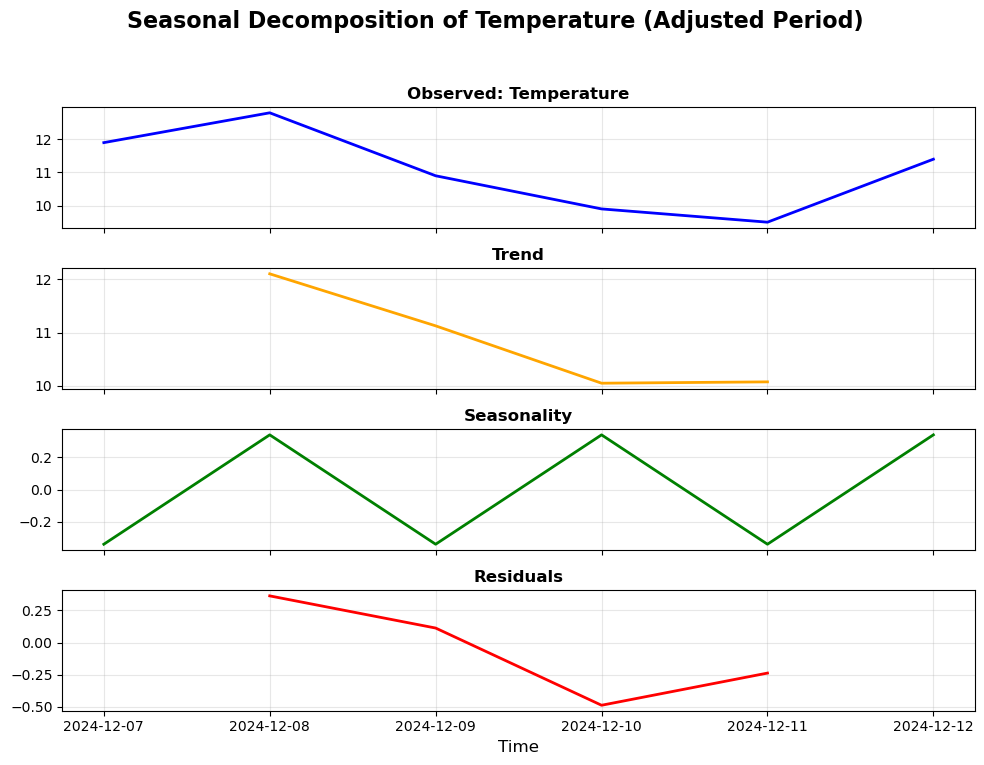

Seasonal Decomposition for wind_speed


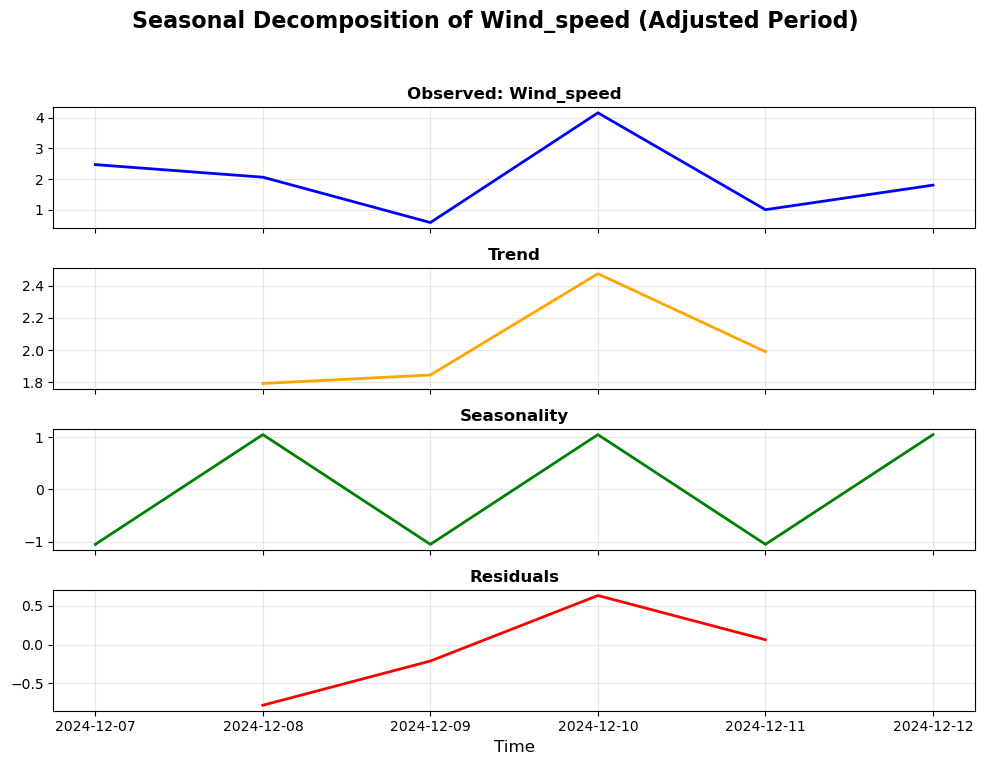

In [70]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


custom_period = 2  

# Columns for decomposition
columns_to_decompose = ["temperature", "wind_speed"]


for column in columns_to_decompose:
    print(f"Seasonal Decomposition for {column}")
    try:
        
        decompose_result = seasonal_decompose(merged_data.set_index("timestamp_local")[column], model="additive", period=custom_period)

        
        fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

        # Observed
        axes[0].plot(decompose_result.observed, color="blue", linewidth=2)
        axes[0].set_title(f"Observed: {column.capitalize()}", fontsize=12, fontweight="bold")
        axes[0].grid(alpha=0.3)

        # Trend
        axes[1].plot(decompose_result.trend, color="orange", linewidth=2)
        axes[1].set_title("Trend", fontsize=12, fontweight="bold")
        axes[1].grid(alpha=0.3)

        # Seasonal
        axes[2].plot(decompose_result.seasonal, color="green", linewidth=2)
        axes[2].set_title("Seasonality", fontsize=12, fontweight="bold")
        axes[2].grid(alpha=0.3)

        # Residuals
        axes[3].plot(decompose_result.resid, color="red", linewidth=2)
        axes[3].set_title("Residuals", fontsize=12, fontweight="bold")
        axes[3].grid(alpha=0.3)

        # Add overall title and format
        fig.suptitle(f"Seasonal Decomposition of {column.capitalize()} (Adjusted Period)", fontsize=16, fontweight="bold")
        plt.xlabel("Time", fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing for title
        plt.show()

    except ValueError as e:
        print(f"Could not perform decomposition for {column}: {e}")


Seasonal Decomposition for soilm_0_10cm


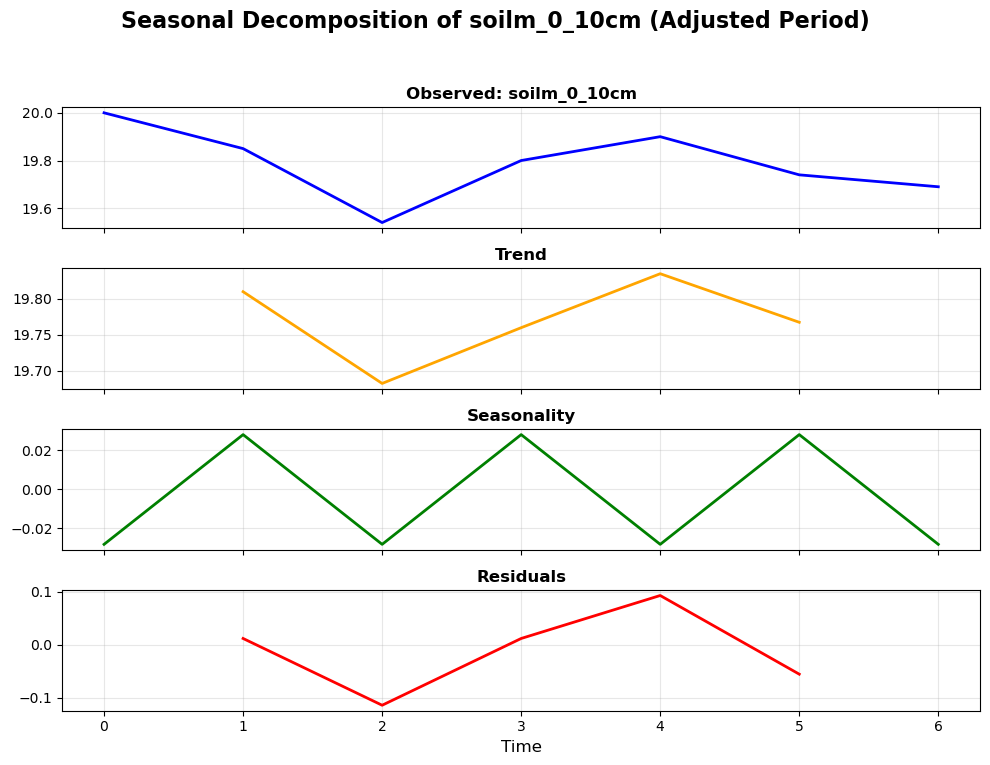

Seasonal Decomposition for soilm_10_40cm


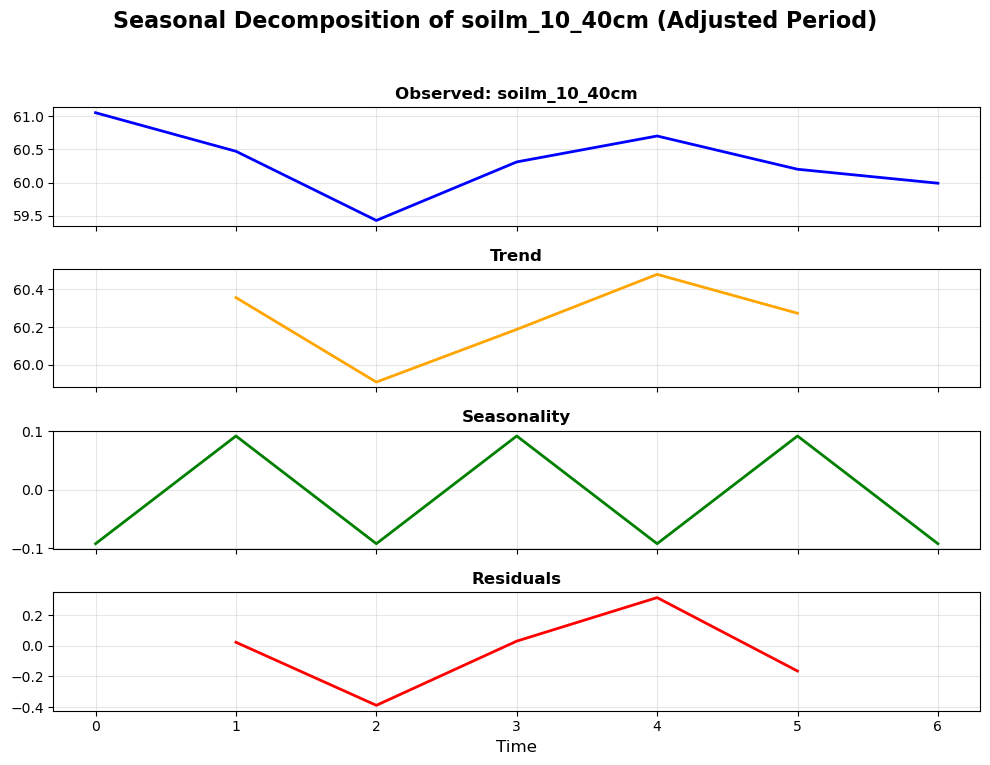

Seasonal Decomposition for soilm_40_100cm


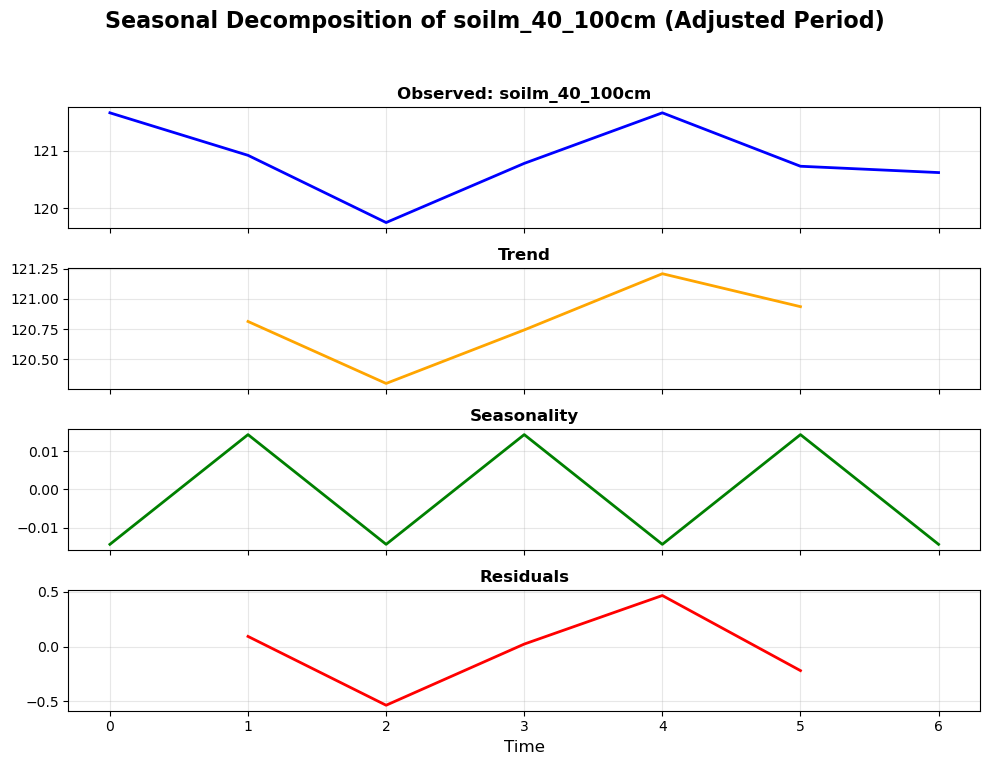

Seasonal Decomposition for soilm_100_200cm


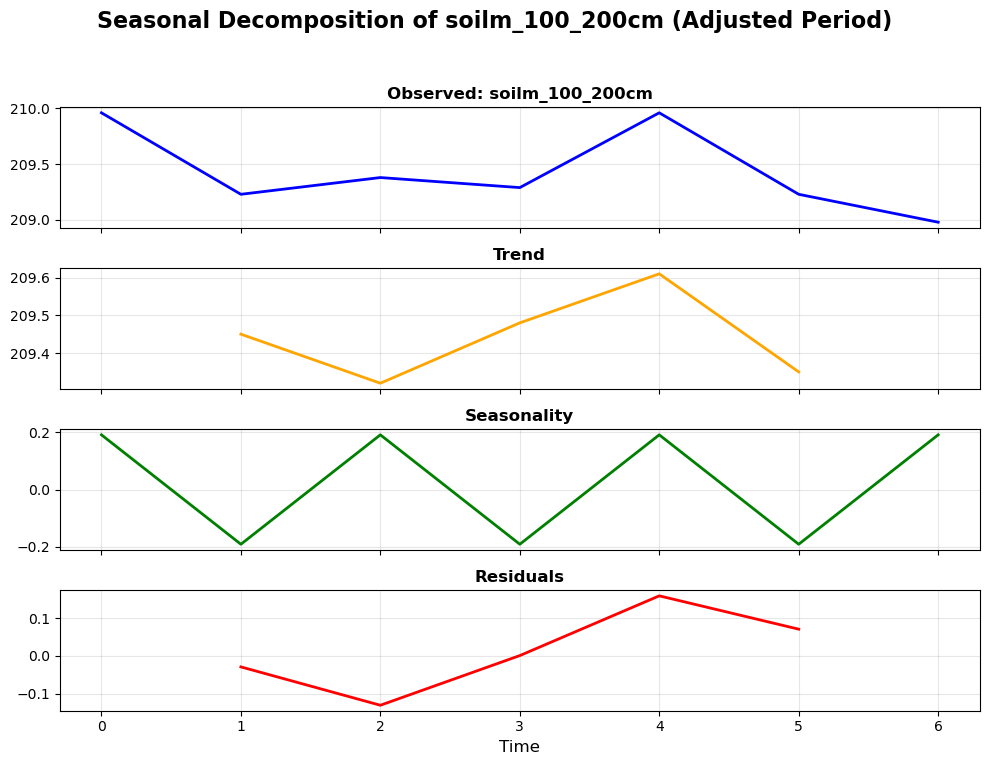

In [71]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


custom_period = 2  


for moisture_level in ["soilm_0_10cm", "soilm_10_40cm", "soilm_40_100cm", "soilm_100_200cm"]:
    print(f"Seasonal Decomposition for {moisture_level}")
    try:
        # Seasonal decomposition
        decompose_result = seasonal_decompose(soil_data[moisture_level], model="additive", period=custom_period)

        # Plot decomposition results with enhanced visuals
        fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

        # Observed
        axes[0].plot(decompose_result.observed, color="blue", linewidth=2)
        axes[0].set_title(f"Observed: {moisture_level}", fontsize=12, fontweight="bold")
        axes[0].grid(alpha=0.3)

        # Trend
        axes[1].plot(decompose_result.trend, color="orange", linewidth=2)
        axes[1].set_title("Trend", fontsize=12, fontweight="bold")
        axes[1].grid(alpha=0.3)

        # Seasonal
        axes[2].plot(decompose_result.seasonal, color="green", linewidth=2)
        axes[2].set_title("Seasonality", fontsize=12, fontweight="bold")
        axes[2].grid(alpha=0.3)

        # Residuals
        axes[3].plot(decompose_result.resid, color="red", linewidth=2)
        axes[3].set_title("Residuals", fontsize=12, fontweight="bold")
        axes[3].grid(alpha=0.3)

        # Add overall title and format
        fig.suptitle(f"Seasonal Decomposition of {moisture_level} (Adjusted Period)", fontsize=16, fontweight="bold")
        plt.xlabel("Time", fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing for title
        plt.show()

    except ValueError as e:
        print(f"Could not perform decomposition for {moisture_level}: {e}")


Cross-Correlation between soilm_0_10cm and soilm_10_40cm


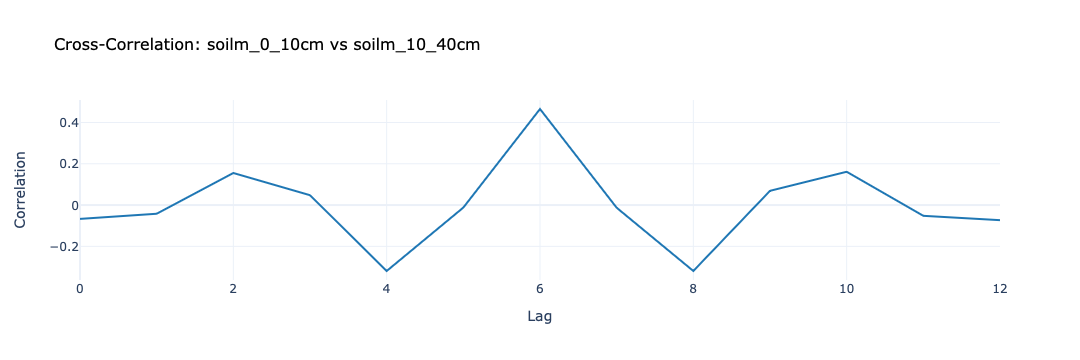

Cross-Correlation between soilm_0_10cm and soilm_40_100cm


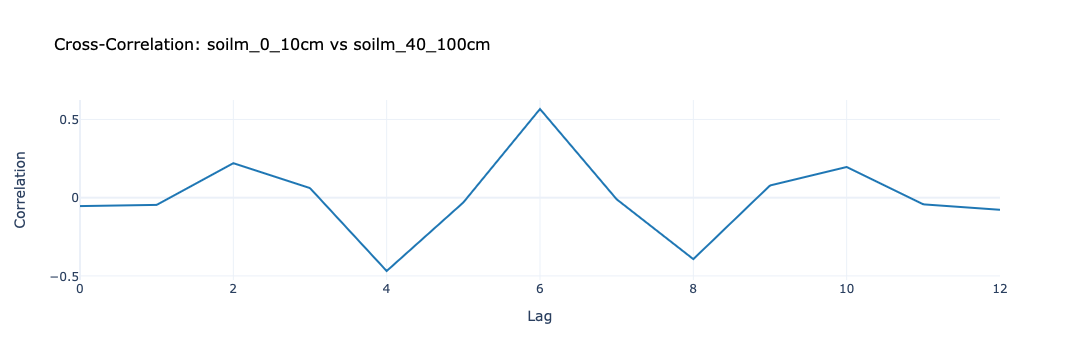

Cross-Correlation between soilm_0_10cm and soilm_100_200cm


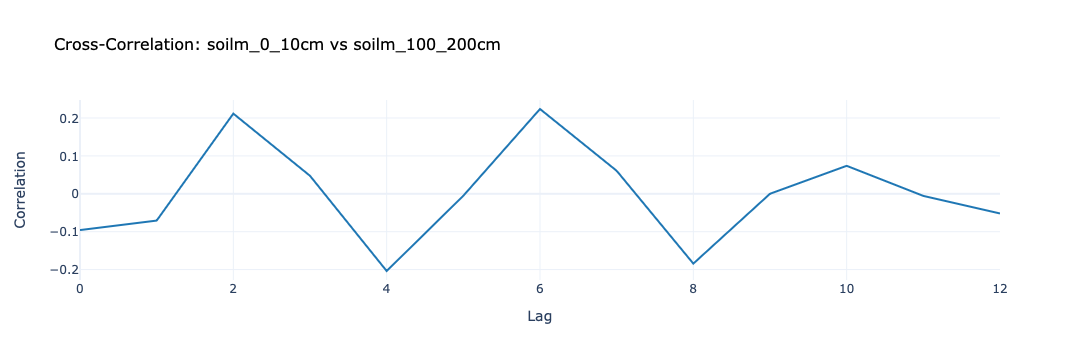

In [72]:
import numpy as np
import plotly.graph_objects as go


for other_moisture in ["soilm_10_40cm", "soilm_40_100cm", "soilm_100_200cm"]:
    print(f"Cross-Correlation between soilm_0_10cm and {other_moisture}")
    correlation = np.correlate(
        soil_data["soilm_0_10cm"] - soil_data["soilm_0_10cm"].mean(),
        soil_data[other_moisture] - soil_data[other_moisture].mean(),
        mode='full'
    )

   
    fig = go.Figure()

   
    fig.add_trace(go.Scatter(
        y=correlation,
        mode='lines',
        line=dict(color='#1f77b4', width=2),
        name=f"Correlation with {other_moisture}"
    ))

    
    fig.update_layout(
        title=f"Cross-Correlation: soilm_0_10cm vs {other_moisture}",
        title_font=dict(size=16, color='black'),
        xaxis_title="Lag",
        yaxis_title="Correlation",
        template="plotly_white",
        xaxis=dict(showgrid=True, zeroline=True),
        yaxis=dict(showgrid=True, zeroline=True),
        hovermode="x"
    )

    
    fig.show()


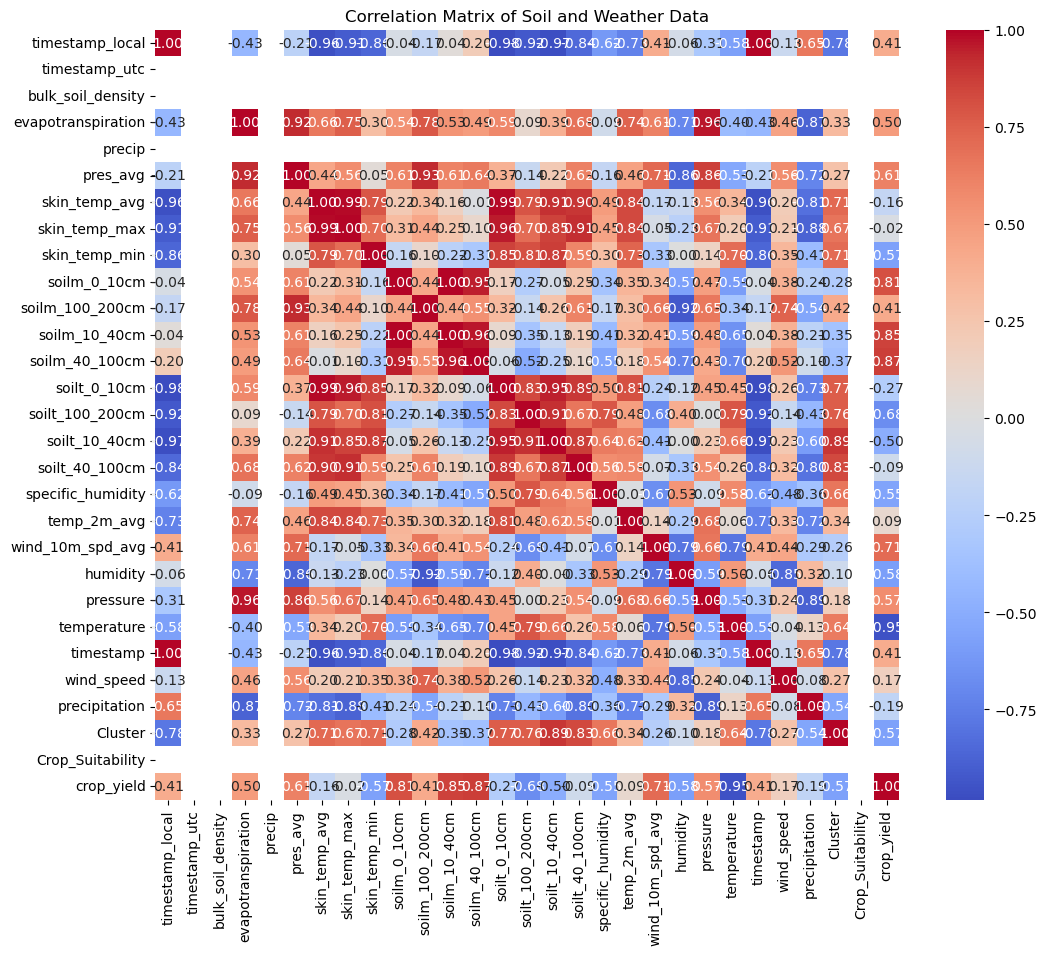

In [73]:

correlation_matrix = merged_data.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Soil and Weather Data")
plt.show()


In [74]:

soil_factors = soil_data.select_dtypes(include=["float64", "int64"]).columns
weather_factors = weather_data.select_dtypes(include=["float64", "int64"]).columns


cross_correlation_results = []


for soil_factor in soil_factors:
    for weather_factor in weather_factors:
        correlation = merged_data[soil_factor].corr(merged_data[weather_factor])
        cross_correlation_results.append({
            "Soil Factor": soil_factor,
            "Weather Factor": weather_factor,
            "Correlation": correlation
        })


cross_correlation_df = pd.DataFrame(cross_correlation_results)


cross_correlation_df = cross_correlation_df.reindex(
    cross_correlation_df["Correlation"].abs().sort_values(ascending=False).index
)


top_n = 10 
top_cross_correlations = cross_correlation_df.head(top_n)

print("Top Cross-Dataset Correlations:")
print(top_cross_correlations)


Top Cross-Dataset Correlations:
           Soil Factor Weather Factor  Correlation
6   evapotranspiration       pressure     0.962167
40     soilm_100_200cm       humidity    -0.921705
29       skin_temp_max  precipitation    -0.879881
9   evapotranspiration  precipitation    -0.874651
15            pres_avg       humidity    -0.864140
16            pres_avg       pressure     0.863743
24       skin_temp_avg  precipitation    -0.812380
74      soilt_40_100cm  precipitation    -0.798584
87    wind_10m_spd_avg    temperature    -0.791373
62     soilt_100_200cm    temperature     0.790982


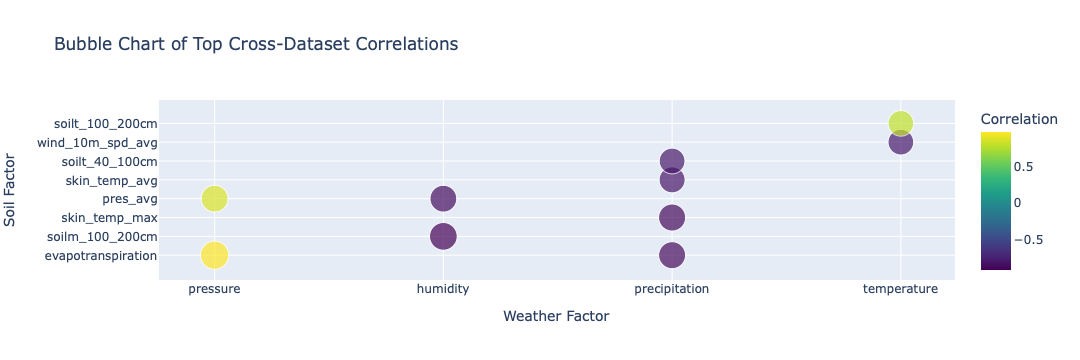

In [75]:
import plotly.express as px


fig = px.scatter(
    top_cross_correlations,
    x="Weather Factor",
    y="Soil Factor",
    size=top_cross_correlations["Correlation"].abs(),  # Bubble size by correlation strength
    color="Correlation",
    hover_name="Correlation",
    title="Bubble Chart of Top Cross-Dataset Correlations",
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.show()


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go



features = ["temperature", "precipitation", "humidity", "pressure", "wind_speed"]
target = "soilm_0_10cm"

X = merged_data[features]
y = merged_data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


fig_metrics = go.Figure()
fig_metrics.add_trace(go.Indicator(
    mode="number",
    value=mse,
    title={"text": "Mean Squared Error (MSE)"},
    domain={"x": [0, 0.5], "y": [0, 1]}
))
fig_metrics.add_trace(go.Indicator(
    mode="number",
    value=r2,
    title={"text": "R2 Score"},
    domain={"x": [0.5, 1], "y": [0, 1]}
))
fig_metrics.update_layout(
    title="Evaluation Metrics",
    template="plotly_white"
)
fig_metrics.show()


importances = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)


print("Feature Importances:")
print(importances)


fig_importance = go.Figure()
fig_importance.add_trace(go.Bar(
    x=importances["Feature"],
    y=importances["Importance"],
    marker=dict(color="skyblue"),
    text=importances["Importance"],
    textposition="outside"
))
fig_importance.update_layout(
    title="Feature Importance for Soil Moisture Prediction",
    xaxis_title="Features",
    yaxis_title="Importance",
    template="plotly_white",
    height=600,
    width=800
)
fig_importance.show()


Mean Squared Error: 0.027652500000001
R2 Score: -0.15098855359003505


Feature Importances:
         Feature  Importance
4     wind_speed    0.344841
2       humidity    0.278344
3       pressure    0.199988
0    temperature    0.125554
1  precipitation    0.051272


/Users/rajsekhar./anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



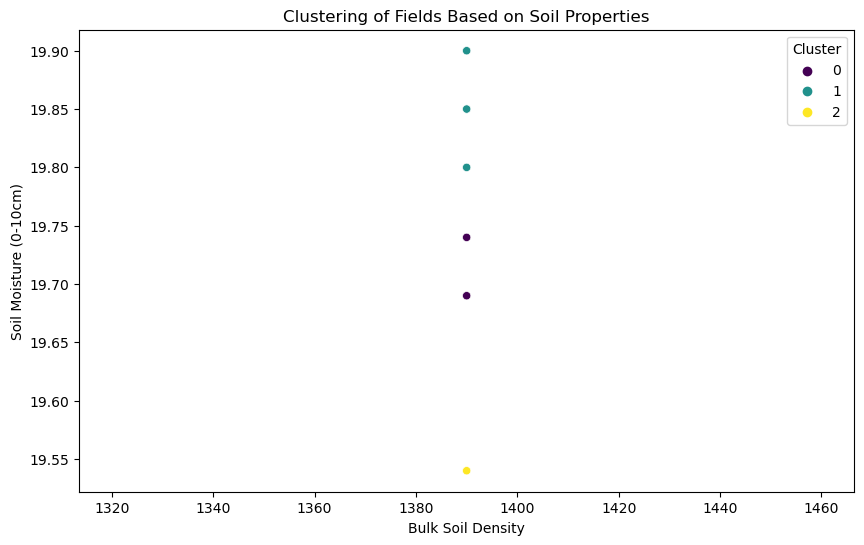

In [77]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


clustering_features = ["bulk_soil_density", "soilm_0_10cm", "soilm_10_40cm", "soilt_0_10cm", "soilt_10_40cm"]


scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data[clustering_features])


kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)


merged_data["Cluster"] = clusters


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=merged_data["bulk_soil_density"], 
    y=merged_data["soilm_0_10cm"], 
    hue=merged_data["Cluster"], 
    palette="viridis"
)
plt.title("Clustering of Fields Based on Soil Properties")
plt.xlabel("Bulk Soil Density")
plt.ylabel("Soil Moisture (0-10cm)")
plt.legend(title="Cluster")
plt.show()


Forecasted Soil Moisture Levels:
2024-12-13    20.042043
2024-12-14    19.824334
2024-12-15    19.767552
2024-12-16    19.970491
2024-12-17    20.060973
2024-12-18    19.751732
2024-12-19    20.011569
2024-12-20    20.109098
2024-12-21    19.946753
2024-12-22    19.898864
Freq: D, Name: predicted_mean, dtype: float64


/Users/rajsekhar./anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rajsekhar./anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rajsekhar./anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rajsekhar./anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/Users/rajsekhar./anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



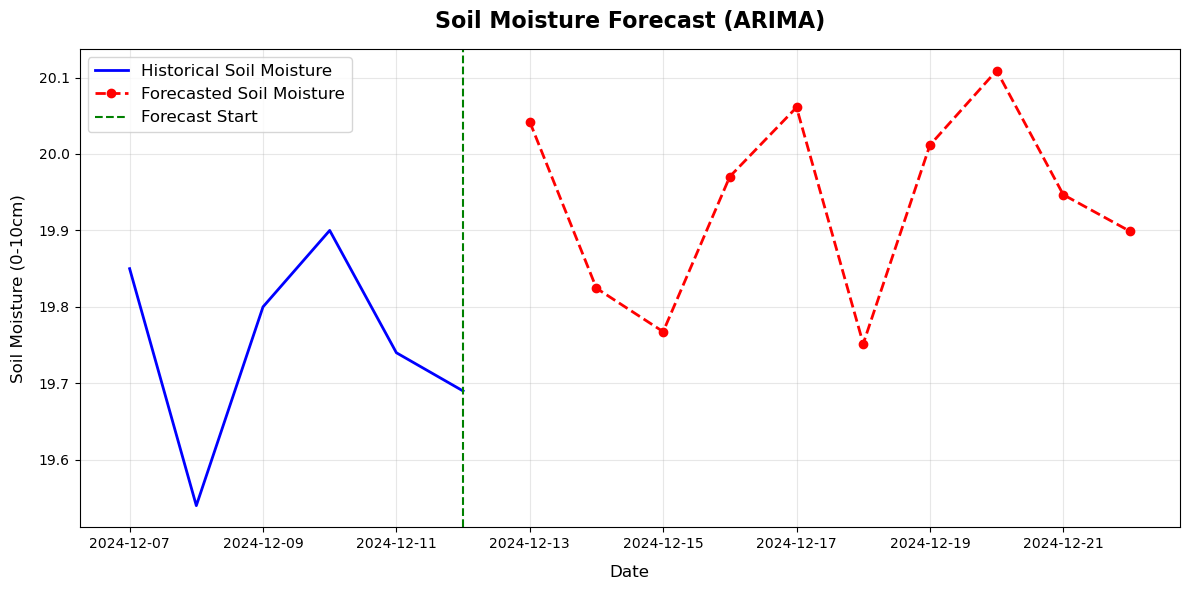

In [81]:
from statsmodels.tsa.arima.model import ARIMA


series = merged_data.set_index("timestamp_local")["soilm_0_10cm"]


model = ARIMA(series, order=(5, 1, 0))  # Adjust order based on ACF/PACF plots
model_fit = model.fit()


forecast = model_fit.forecast(steps=10)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=10, freq="D")
forecast_series = pd.Series(forecast, index=forecast_index)


print("Forecasted Soil Moisture Levels:")
print(forecast_series)


plt.figure(figsize=(12, 6))
plt.plot(series[-50:], label="Historical Soil Moisture", color="blue", linewidth=2)
plt.plot(forecast_series, label="Forecasted Soil Moisture", color="red", linestyle="--", marker="o", linewidth=2)
plt.axvline(series.index[-1], color="green", linestyle="--", label="Forecast Start", linewidth=1.5)


plt.title("Soil Moisture Forecast (ARIMA)", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Date", fontsize=12, labelpad=10)
plt.ylabel("Soil Moisture (0-10cm)", fontsize=12, labelpad=10)


plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()


plt.show()


In [79]:
merged_data["crop_yield"] = (
    10 * merged_data["soilm_0_10cm"].astype(float) + 
    5 * merged_data["precip"].astype(float) - 
    2 * merged_data["temperature"].astype(float)
)


features = [
    "soilm_0_10cm", "soilm_10_40cm", "precip", "temperature",
    "humidity", "wind_speed", "evapotranspiration"
]
target = "crop_yield"

X = merged_data[features]
y = merged_data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


feature_importances = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Feature Importances:")
print(feature_importances)




Mean Squared Error (MSE): 21.51
R-squared (R2): -2.58
Feature Importances:
              Feature  Importance
4            humidity    0.225563
3         temperature    0.222559
1       soilm_10_40cm    0.165819
6  evapotranspiration    0.149403
0        soilm_0_10cm    0.148802
5          wind_speed    0.087855
2              precip    0.000000


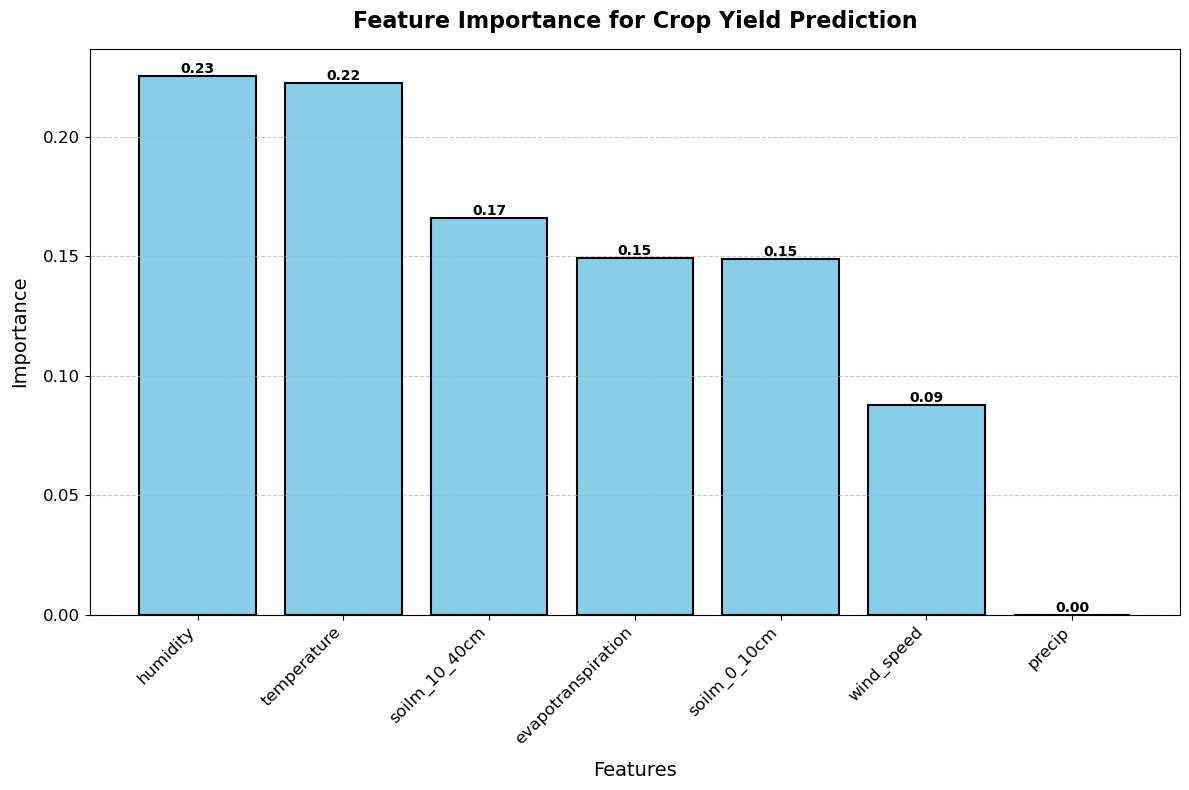

In [80]:




plt.figure(figsize=(12, 8))
bars = plt.bar(
    feature_importances["Feature"], 
    feature_importances["Importance"], 
    color="skyblue", 
    edgecolor="black", 
    linewidth=1.5
)


for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height(), 
        f"{bar.get_height():.2f}", 
        ha="center", 
        va="bottom", 
        fontsize=10, 
        fontweight="bold"
    )


plt.title("Feature Importance for Crop Yield Prediction", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Features", fontsize=14, labelpad=10)
plt.ylabel("Importance", fontsize=14, labelpad=10)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()


plt.show()
